# Projeto Tópicos 6 — Treinamento Parcial (Entrega 21/11)
## Classificação de Toxicidade (Jigsaw) com BERT + MPS (GPU Mac)


In [1]:
import torch

print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

MPS available: True
MPS built: True
Using device: mps


# 1) Carregar dataset CSV (Kaggle)

In [2]:
from datasets import load_dataset

dataset = load_dataset(
    "csv",
    data_files={"train": "dataset/train.csv"}
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 159571
    })
})

# 2) Criar coluna labels multi-label

In [3]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def add_labels(example):
    example["labels"] = [example[c] for c in label_cols]
    return example

dataset["train"] = dataset["train"].map(add_labels)

dataset["train"][0]["labels"]

[0, 0, 0, 0, 0, 0]

# 3) Split train/val (10%)

In [5]:
split = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_ds = split["train"]
val_ds   = split["test"]

len(train_ds), len(val_ds)

(143613, 15958)

# 4) Reduzir dataset para não travar CPU/MPS

In [6]:
train_ds = train_ds.shuffle(seed=42).select(range(20000))  # 20k
val_ds   = val_ds.shuffle(seed=42).select(range(2000))     # 2k

len(train_ds), len(val_ds)

(20000, 2000)

# 5) Tokenização segura (sem padding fixo) + Remoção de colunas


In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import AutoTokenizer

model_name = "bert-base-uncased"

# Importante: tokenizer lento evita crash no Python 3.14
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize(batch):
    return tokenizer(
        batch["comment_text"],
        truncation=True,
        max_length=64  # mais leve e suficiente p/ entrega parcial
    )

# --- Tokenizar com batch pequeno e sem cache ---
train_ds = train_ds.map(
    tokenize,
    batched=True,
    batch_size=64,
    load_from_cache_file=False,
    keep_in_memory=False
)

val_ds = val_ds.map(
    tokenize,
    batched=True,
    batch_size=64,
    load_from_cache_file=False,
    keep_in_memory=False
)

# --- Remover colunas que quebram o DataCollator ---
cols_to_keep = ["input_ids", "attention_mask", "labels"]

train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols_to_keep])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in cols_to_keep])

print("Colunas após limpeza:")
print(train_ds.column_names)
print(val_ds.column_names)

/Users/hitalo/Documents/topicos-6/projeto/.venv/lib/python3.14/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/hitalo/Documents/topicos-6/projeto/.venv/lib/python3.14/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map: 100%|##########| 20000/20000 [00:00<?, ? examples/s]

Map: 100%|##########| 2000/2000 [00:00<?, ? examples/s]

Colunas após limpeza:
['labels', 'input_ids', 'attention_mask']
['labels', 'input_ids', 'attention_mask']


# 5.1) Criar DataLoaders com collator dinâmico


In [8]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    collate_fn=collator,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    collate_fn=collator,
    num_workers=0,
    pin_memory=False
)

# 6) Carregar modelo BERT Multi-Label


In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    problem_type="multi_label_classification"
)

model.to(device)


/Users/hitalo/Documents/topicos-6/projeto/.venv/lib/python3.14/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/hitalo/Documents/topicos-6/projeto/.venv/lib/python3.14/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# 7) Otimizador + Scheduler

In [10]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import numpy as np

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 1  # treino parcial — suficiente para a entrega

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 8) Funções de Treino / Validação


In [11]:
def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0.0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].float().to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    total_loss = 0.0

    all_logits = []
    all_labels = []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].float().to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        total_loss += outputs.loss.item()
        all_logits.append(outputs.logits.cpu())
        all_labels.append(labels.cpu())

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()

    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)

    f1 = f1_score(labels, preds, average="micro")
    avg_loss = total_loss / len(loader)

    return avg_loss, f1

# 9) Loop de Treinamento Parcial


In [12]:
num_epochs = 1  # ou 2, se quiser

history = {"train_loss": [], "val_loss": [], "val_f1": []}

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler)
    val_loss, val_f1 = eval_model(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_f1"].append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train loss: {train_loss:.4f}")
    print(f"  Val loss:   {val_loss:.4f}")
    print(f"  Val F1:     {val_f1:.4f}")

Epoch 1/1
  Train loss: 0.0695
  Val loss:   0.0535
  Val F1:     0.7391


# 10) Gráficos para o Relatório


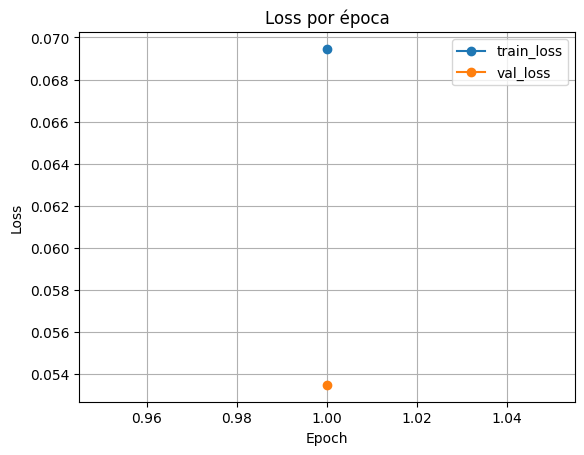

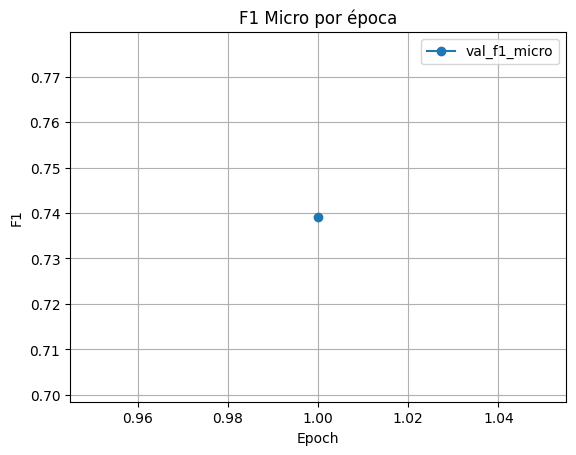

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(history["train_loss"]) + 1))

# Loss
plt.figure()
plt.plot(epochs, history["train_loss"], marker="o", label="train_loss")
plt.plot(epochs, history["val_loss"], marker="o", label="val_loss")
plt.title("Loss por época")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# F1
plt.figure()
plt.plot(epochs, history["val_f1"], marker="o", label="val_f1_micro")
plt.title("F1 Micro por época")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(True)
plt.show()

# 11) Validação adicional (exemplos reais)

In [15]:
def predict(texts):
    enc = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    probs = torch.sigmoid(logits).cpu().numpy()
    return probs

samples = [
    "I love this article, very helpful.",
    "You are stupid and disgusting.",
    "I'll find you and hurt you.",
    "Thank you for your support!",
]

preds = predict(samples)

for text, p in zip(samples, preds):
    print("\nTexto:", text)
    clean_output = {label: float(prob) for label, prob in zip(label_cols, p)}
    # arredonda para 3 casas (opcional)
    clean_output = {k: round(v, 3) for k, v in clean_output.items()}
    print("Predições:", clean_output)



Texto: I love this article, very helpful.
Predições: {'toxic': 0.005, 'severe_toxic': 0.002, 'obscene': 0.003, 'threat': 0.002, 'insult': 0.004, 'identity_hate': 0.003}

Texto: You are stupid and disgusting.
Predições: {'toxic': 0.928, 'severe_toxic': 0.081, 'obscene': 0.636, 'threat': 0.041, 'insult': 0.641, 'identity_hate': 0.109}

Texto: I'll find you and hurt you.
Predições: {'toxic': 0.567, 'severe_toxic': 0.023, 'obscene': 0.14, 'threat': 0.031, 'insult': 0.252, 'identity_hate': 0.049}

Texto: Thank you for your support!
Predições: {'toxic': 0.006, 'severe_toxic': 0.002, 'obscene': 0.003, 'threat': 0.002, 'insult': 0.004, 'identity_hate': 0.003}


# 12) Salvar modelo treinado (baseline)


In [16]:
save_path = "baseline_model"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Modelo salvo em: {save_path}")

Modelo salvo em: baseline_model


In [ ]:
# Para carregar o modelo salvo posteriormente:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# model = AutoModelForSequenceClassification.from_pretrained("baseline_model")
# tokenizer = AutoTokenizer.from_pretrained("baseline_model")
